In [17]:

import os.path
import json

import pandas as pd
import matplotlib.pyplot as plt

from google.auth.transport.requests import Request
from google.oauth2.credentials import Credentials
from google_auth_oauthlib.flow import InstalledAppFlow
from googleapiclient.discovery import build
from googleapiclient.errors import HttpError



In [9]:
# If modifying these scopes, delete the file token.json.
# Habilita apenas a leitura do arquivo
# SCOPES = ["https://www.googleapis.com/auth/spreadsheets.readonly"]

SCOPES = ["https://www.googleapis.com/auth/spreadsheets"]

creds = None
if os.path.exists("token.json"):
    creds = Credentials.from_authorized_user_file("token.json", SCOPES)
if not creds or not creds.valid:
    if creds and creds.expired and creds.refresh_token:
        creds.refresh(Request())
    else:
        flow = InstalledAppFlow.from_client_secrets_file(
            "client_secret.json", SCOPES
        )
        creds = flow.run_local_server(port=0)
    # Save the credentials for the next run
    with open("token.json", "w") as token:
        token.write(creds.to_json())

        

In [13]:
with open("spreadsheetID.json", "r", encoding="utf-8") as sheet_id:
    spreadsheetid = json.load(sheet_id).get("spreadsheetId")
    
service = build("sheets", "v4", credentials=creds)

# Call the Sheets API
sheet = service.spreadsheets()
result = (
    sheet.values()
    .get(spreadsheetId=spreadsheetid, 
            range="Página1!A1:B12")            
    .execute()
)
values = result.get("values", [])


df = pd.DataFrame(values[1:], columns=values[0])

In [21]:
df

,Mês,Vendas
0,Janeiro,"$58,915.00"
1,Fevereiro,"$18,697.00"
2,Março,"$55,824.00"
3,Abril,"$62,563.00"
4,Maio,"$66,697.00"
5,Junho,"$68,780.00"
6,Julho,"$49,528.00"
7,Agosto,"$58,897.00"
8,Setembro,"$88,473.00"
9,Outubro,"$22,810.00"


In [26]:
df["Vendas"] = df["Vendas"].apply(lambda x: float(str(x).replace(",", "").replace("$", "")))

In [27]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11 entries, 0 to 10
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Mês     11 non-null     object 
 1   Vendas  11 non-null     float64
dtypes: float64(1), object(1)
memory usage: 308.0+ bytes


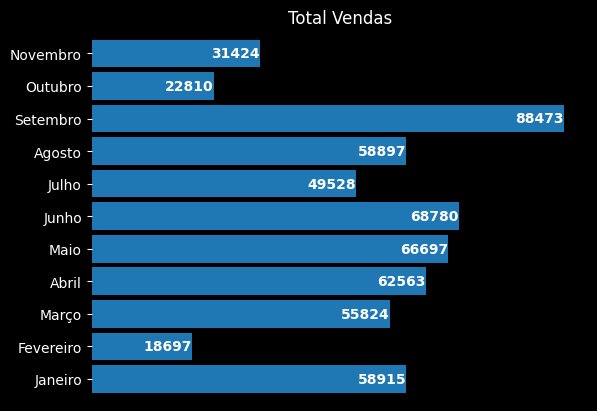

In [109]:
ax = df.plot.barh(x="Mês", y="Vendas", legend=False, width=0.85)

plt.gcf().set_facecolor('#000000')

# Removendo o quadro do gráfico
for spine in ax.spines.values():
    spine.set_visible(False)

# Add backgroud-color grafico
ax.set_facecolor("#000000")
# Removendo o eixo x
ax.get_xaxis().set_visible(False)

# Removendo o eixo Y
# ax.get_yaxis().set_visible(False)

# Alterando a cor dos ticks e rótulos do eixo Y
ax.tick_params(axis='y', colors='white')  # Cor dos ticks do eixo Y

for i in range(len(df)):
    ax.text(df["Vendas"].iloc[i], i, f'{df["Vendas"].iloc[i]:.0f}', ha="right", va="center", color="white", fontweight='bold', fontsize=10)

# Removendo os rótulos dos eixos X e Y
plt.title("Total Vendas", color='white')
plt.xlabel("")  # Remove o rótulo do eixo X
plt.ylabel("")  # Remove o rótulo do eixo Y

plt.show()